In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import ascii
from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle

In [2]:
#Define handy functions to be used later
def binner(bins, time, flux):
    means, errors = [], []
    midpoints = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
    for i in range(len(bins)-1):
        binned_mask = (time < bins[i+1])*(time > bins[i])
        means.append(np.mean(flux[binned_mask]))
        errors.append(np.std(flux[binned_mask])/np.sqrt(len(flux[binned_mask])))
    return means, errors, midpoints

def ringaling(phi,*c):
    # c is a numpy array containing an odd number of coeffieicnts
    # so that c[0] + c[1]*np.sin(phi) + c[2]*np.cos(phi) + c[3]*np.sin(2*phi) + c[4]*np.cos(2*phi) + .....
    c = np.array(c)
    npairs = (c.size-1)/2
    result = 0
    for i in np.arange(npairs):
        a_sin = c[((i*2)+1).astype(int)]
        a_cos = c[((i*2)+2).astype(int)]
        result = result + a_sin*np.sin(phi*(i+1)) + a_cos*np.cos(phi*(i+1))
    return result+c[0]

## Cleaning the Data

In [3]:
#Get the data directory
cwd = os.getcwd()
data_dir = cwd.replace('Figure_3', 'Data\\')

tess = ascii.read(data_dir + 'J1407_TESS.txt')

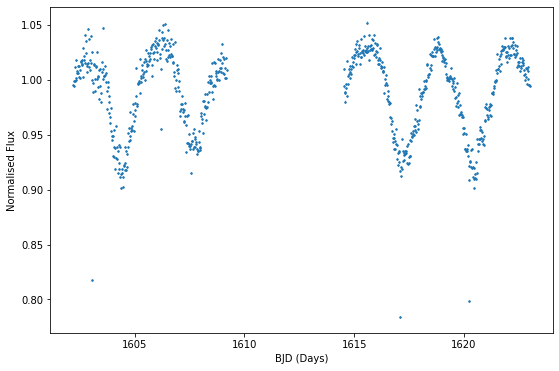

In [4]:
time = tess['col1']
flux = tess['col2']
eflux = tess['col3']

#Remove parts of the flux that are not trusted
mask = (time > 1602.2)*(eflux < 1000)*(flux > 100)*(time < 1623) 
time = time[mask]
flux = flux[mask]
eflux = eflux[mask]

#Remove the central section of flux by eye, as it is contaminated
shaky_mask = (time > 1609.2) * (time < 1614.5)
time_f = time[~shaky_mask]
flux = flux[~shaky_mask]
eflux = eflux[~shaky_mask]

#Normalise to the median
flux_f = flux/np.median(flux)
eflux_f = eflux/np.median(flux)

#Finally, the remaining, uncorrected flux looks like this, showing the 3.2 day variation very clearly
plt.errorbar(time_f, flux_f, eflux_f, fmt='.', markersize= 3, elinewidth=0.5)
plt.ylabel('Normalised Flux')
plt.xlabel('BJD (Days)')
figure = plt.gcf()
figure.set_size_inches(9, 6)
plt.show()

## Removing the Periodic Signals

The highest power period is for  3.200  days.


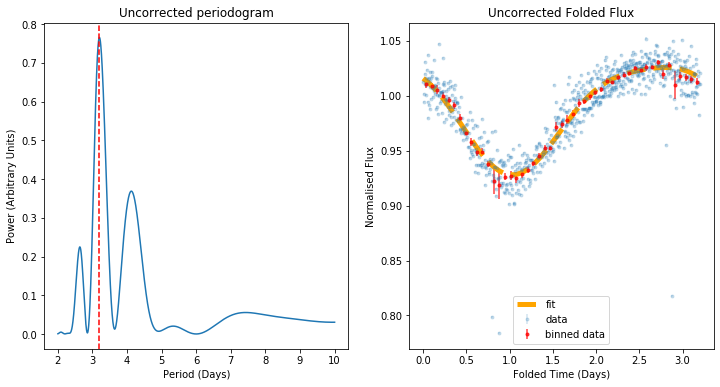

In [5]:
fig, ax = plt.subplots(1, 2)

frequencies = 1/np.linspace(2, 10, 3000)
power = LombScargle(time_f, flux_f-np.mean(flux_f), dy = eflux_f).power(frequencies)
max_period = 1/frequencies[list(power).index(np.max(power))]
print("The highest power period is for ", '{0:.3f}'.format(max_period), ' days.')


ax[0].plot(1/frequencies, power)
ax[0].axvline(x = max_period, c= 'r', linestyle = '--')
ax[0].set_xlabel("Period (Days)")
ax[0].set_ylabel("Power (Arbitrary Units)")
ax[0].set_title('Uncorrected periodogram')
power_lim = ax[0].set_ylim()

#Fold the time data to the highest power signal
time_folded = time_f%max_period
means, errors, midpoints = binner(np.linspace(0, max_period, 50), time_folded, flux_f) #Bin the time folded data

#Fit the ringaling function to the binned data
popt, pcov = curve_fit(ringaling, np.array(midpoints)*2*np.pi/(max_period), means, sigma = errors, absolute_sigma = True, p0 = [1,0,0, 1, 1])
phi = np.arange(200)*2*np.pi / 200

#Plot the best fit
ax[1].errorbar(time_folded, flux_f, eflux_f, fmt = '.', label = 'data', alpha = 0.2)
ax[1].errorbar(midpoints, means, errors, fmt = '.', label = 'binned data', alpha = 0.75, c = 'r')
ax[1].set_title('Uncorrected Folded Flux')
ax[1].set_xlabel('Folded Time (Days)')
ax[1].set_ylabel('Normalised Flux')
ax[1].plot(phi*max_period/(2*np.pi), ringaling(phi, *popt), linestyle = '--', c= 'orange', label= 'fit', lw =5)
ax[1].legend()
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.show()

#Correct the flux by subtracting the best fit
flux_32_corr = flux_f-ringaling(time_folded*2*np.pi/(max_period), *popt) 

The highest power period is for  8.330  days.
The best fit parameters are  [-0.0008093  -0.0054403   0.00635436 -0.00316363  0.00040704]


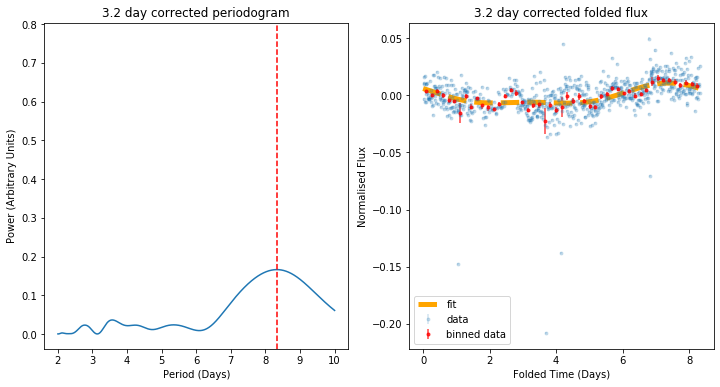

In [6]:
#Stil there is some periodicity remaining, so we repeat the above recipe once more

fig, ax = plt.subplots(1, 2)

frequencies = 1/np.linspace(2, 10, 3000)
power = LombScargle(time_f, flux_32_corr-np.mean(flux_32_corr), dy = eflux_f).power(frequencies)
max_period = 1/frequencies[list(power).index(np.max(power))]
print("The highest power period is for ", '{0:.3f}'.format(max_period), ' days.')

ax[0].plot(1/frequencies, power)
ax[0].axvline(x = max_period, c= 'r', linestyle = '--')
ax[0].set_ylim(power_lim)
ax[0].set_title('3.2 day corrected periodogram')
ax[0].set_xlabel("Period (Days)")
ax[0].set_ylabel("Power (Arbitrary Units)")

time_folded = time_f%max_period
means, errors, midpoints = binner(np.linspace(0, max_period, 50), time_folded, flux_32_corr)

popt, pcov = curve_fit(ringaling, np.array(midpoints)*2*np.pi/(max_period), means, sigma = errors, absolute_sigma = True, p0 = [1,0,0, 1, 1])
print("The best fit parameters are ", popt)
phi = np.arange(200)*2*np.pi / 200


ax[1].errorbar(time_folded, flux_32_corr, eflux_f, fmt = '.', label = 'data', alpha = 0.2)
ax[1].errorbar(midpoints, means, errors, fmt = '.', label = 'binned data', alpha = 0.75, c = 'r')
ax[1].set_title('3.2 day corrected folded flux')
ax[1].set_xlabel('Folded Time (Days)')
ax[1].set_ylabel('Normalised Flux')
ax[1].plot(phi*max_period/(2*np.pi), ringaling(phi, *popt), linestyle = '--', c= 'orange', label= 'fit', lw =5)
ax[1].legend()
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.show()

flux_32et83_corr = flux_32_corr-ringaling(time_folded*2*np.pi/(max_period), *popt) #Again subtract the best fit, removing the final strong signals

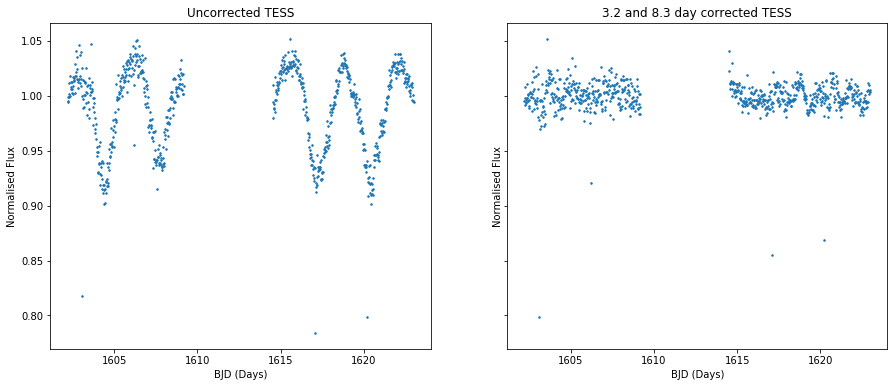

In [7]:
#A nice comparison to observe the removed signal
fig, ax = plt.subplots(1, 2, sharey = True)

ax[0].errorbar(time_f, flux_f, eflux_f, fmt='.', markersize= 3, elinewidth=0.5)
ax[0].set_title("Uncorrected TESS")
ax[0].set_xlabel("BJD (Days)")
ax[0].set_ylabel("Normalised Flux")
figure = plt.gcf()
figure.set_size_inches(12, 9)

ax[1].errorbar(time_f, flux_32et83_corr+1, eflux_f, fmt='.', markersize= 3, elinewidth=0.5)
ax[1].set_xlabel("BJD (Days)")
ax[1].set_ylabel("Normalised Flux")
ax[1].set_title("3.2 and 8.3 day corrected TESS")
figure = plt.gcf()
figure.set_size_inches(15, 6)
plt.show()

## Creating the Figure

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


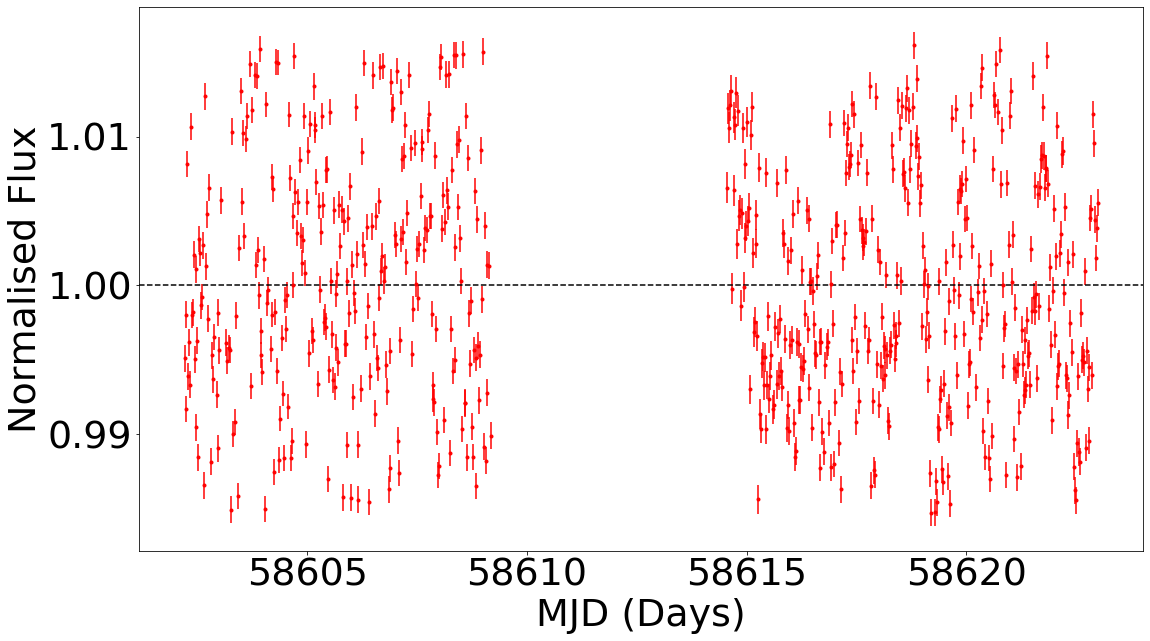

In [8]:
#Create the figure in the paper
import matplotlib
plt.style.use('seaborn-dark-palette')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 38}
matplotlib.rc('font', **font)

#Remove the outliers
low, high = np.percentile(flux_32et83_corr,[5, 95])
scat_mask = (flux_32et83_corr < high)*(flux_32et83_corr > low)
time_f, flux_32et83_corr, eflux_f = time_f[scat_mask], flux_32et83_corr[scat_mask], eflux_f[scat_mask]

tess_final = np.zeros((len(time_f), 3))
tess_final[:, 0] = time_f
tess_final[:, 1] = flux_32et83_corr+1
tess_final[:, 2] = eflux_f

plt.errorbar(tess_final[:, 0]+57000, tess_final[:, 1], tess_final[:, 2], fmt='.', c='r')
plt.axhline(y = 1.0, linestyle = '--', c='black')
plt.xlabel('MJD (Days)')
plt.ylabel("Normalised Flux")
figure = plt.gcf()
figure.set_size_inches(18, 10)
#plt.savefig("TESS_New_Elenor_LC.pdf")
plt.show()